## Import libs

In [4]:
from __future__ import print_function, division, absolute_import
import os
import GPy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy import signal
import sys
sys.path.insert(0,'../..')
print(sys.path)
from mtfunc.helper import *
import safeopt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import tqdm
import tensorflow as tf
from tensorflow import keras
# plt.style.use('science')

# # mpl.rcParams['axes.grid.axis']='y'
# mpl.rcParams['legend.markerscale']=8
# mpl.rcParams['text.usetex']=True

hour=60
day=24*hour
C=96 #kWh
soc_lim=np.array([30,80])
p_bat_lim=1*C #1C 
p_std=p_bat_lim
soc_std=soc_lim[1]-soc_lim[0]# do not change unless necesary
soc_ref=(soc_lim[1]+soc_lim[0])/2
dt=60
S_os_max=10 # max overshoot of SoC; ex. SoC_max=soc_lim[1]+S_os_max
print(p_std,soc_std)

['../..', '..', '/Users/adrianpaeckelripoll/rbc-parameter-tuning/fig_scripts/demand_power', '/opt/anaconda3/envs/env1/lib/python39.zip', '/opt/anaconda3/envs/env1/lib/python3.9', '/opt/anaconda3/envs/env1/lib/python3.9/lib-dynload', '', '/opt/anaconda3/envs/env1/lib/python3.9/site-packages', '/opt/anaconda3/envs/env1/lib/python3.9/site-packages/IPython/extensions', '/Users/adrianpaeckelripoll/.ipython']
/Users/adrianpaeckelripoll/rbc-parameter-tuning/mtfunc   was appended to PYTHONPATH
96 50


In [2]:
# rdata1=pd.read_csv("/Users/adrianpaeckelripoll/rbc-parameter-tuning/data/solar_irradiance_forecast.csv")
# rdata1.timestamp=pd.to_datetime(rdata1.timestamp,unit='ns')
# rdata1.set_index('timestamp',inplace=True)
# rdata1=rdata1.resample(f'{dt}T').mean().interpolate().dropna()

rdata0=pd.read_csv("/Users/adrianpaeckelripoll/rbc-parameter-tuning/data/nest_data_tot_3.csv")
rdata0.timestamp=pd.to_datetime(rdata0.timestamp,unit='ns')
rdata0.set_index('timestamp',inplace=True)
rdata0=rdata0.sort_index()
rdata0=rdata0.resample(f'{dt}T').mean().interpolate().dropna()
rdata0.rename(columns={'poewr_umr':'power_umr'},inplace=True)
# rdata=pd.concat([rdata0,rdata1],axis=1)
rdata=rdata0
rdata=rdata.loc[:,~rdata.columns.duplicated()]
rdata.rename(columns={'global_radiation_fc':'sun_fc'},inplace=True)

In [3]:
# winter=rdata[pd.Timestamp('2021-11-01'):pd.Timestamp('2021-11-30')].copy()
summer=rdata[pd.Timestamp('2021-07-01'):pd.Timestamp('2021-08-15')].copy()
spring=rdata[pd.Timestamp('2021-04-01'):pd.Timestamp('2021-05-15')].copy()
winter=rdata[pd.Timestamp('2021-12-15'):pd.Timestamp('2022-01-25')].copy()
trimester1=rdata[pd.Timestamp('2021-01-01'):pd.Timestamp('2021-04-01')].copy()
trimester2=rdata[pd.Timestamp('2021-04-01'):pd.Timestamp('2021-07-01')].copy()
trimester3=rdata[pd.Timestamp('2021-07-01'):pd.Timestamp('2021-10-01')].copy()
trimester4=rdata[pd.Timestamp('2021-10-01'):pd.Timestamp('2022-01-01')].copy()

# data=rdata[pd.Timestamp('2019-10-01'):].copy()
# data=summer

def data_prepocess(data,rss_bounds=None):

    pv_signals=['power_pv_sfw_t100', 'power_pv_sfw_t101','power_pv_sfw_t102',
                'power_pv_sol_t100','power_pv_meter_dfab','power_pv_move','power_pv_move_t100']
    loads=['power_sfw', 'power_dfab', 'power_sol','power_vw','power_umr','power_m2c','power_move']
    data.power_pv_dfab_t100=-data.power_pv_dfab_t100
    data['power_pv']=data[pv_signals].sum(axis=1)
    data['soc'] = data[['soc_min', 'soc_max']].mean(axis=1)
    data['power_load']=data[loads].sum(axis=1)
    data['power_demand']=data.power_load-data.power_pv
    inputs_demand=['power_demand','outside_temperature_fc',
        'day_sin','day_cos']
        
    inputs_PV=['sun_fc', 'outside_temperature_fc', 'rh_outside_fc',
       'solar_elevation', 'solar_azimuth'] 
    # data['power_pv_fc']=np.dot(np.transpose(np.atleast_2d(data.sun_fc.values)),phipv)
    signals=list((set(['power_load','power_bypass_ehub','power_bat_meter','power_ehub','power_demand','soc','power_pv'])|set(inputs_demand) |set(inputs_PV))&set(data.columns.values))         

    data=data[signals].apply(gaussian_filter1d,sigma=2,raw=True)
    # data.reset_index(inplace=True)

    data['power_load_']=np.clip(data.power_load,-p_bat_lim,p_bat_lim)
    data['pp']=data.power_load_[data.power_load>0]
    data.pp=data.pp.fillna(0)
    data['pm']=data.power_load_[data.power_load<=0]
    data.pm=data.pm.fillna(0)
    data.drop(columns='power_load_',inplace=True)

    data['e_dis']=data.pp.rolling(window=day//dt).sum()/hour*dt/C #kWh
    data['e_char']=data.pm.rolling(window=day//dt).sum()/hour*dt/C #kWh
    data.e_char=data.e_char.abs()
    data.e_char=np.clip(data.e_char,0,np.diff(soc_lim)[0]/100)
#     data.pm=data.pm/C
#     data.pp=data.pp/C
    data['Rss']=np.clip(data.e_char/data.e_dis,0,1)

    data['Rss_max']=np.clip(data.e_char/np.clip(data.e_dis,0,np.diff(soc_lim)[0]/100),0,1)
    data.loc[:,'Rss_day']=data.asfreq('D').resample('T').bfill().Rss
    data.loc[:,'e_ch_day']=data.asfreq('D').resample('T').bfill().e_char
    print('Cos/sin week start on: ',data.index[0].strftime('%A'))
    data=data.reset_index(drop=False)
    data['time']=data.index*dt
    data['day_sin']=np.sin(2*np.pi*data.time/day)
    data['day_cos']=np.cos(2*np.pi*data.time/day)
    data['week_sin']=np.sin(2*np.pi*data.time/day/7)
    data['week_cos']=np.cos(2*np.pi*data.time/day/7)
    
    data=data.set_index('timestamp',drop=True)
    data=data.drop(columns='time')
    data.power_pv=-data.power_pv
    if rss_bounds is not None:
        return data.loc[(data.Rss_day>rss_bounds[0])&(data.Rss_day<rss_bounds[1])].shift(1).dropna()
    else:
        return data.shift(1).dropna()

In [111]:
demand_model=tf.keras.models.load_model('../saved_models/loss_demand_convtd_1dpowerdemand_Tfc_dayweeksincos_7w')
demand_modelval=tf.keras.models.load_model('../saved_models/s1val_loss_demand_convtd_1dpowerdemand_Tfc_dayweeksincos_7w')
PV_model=tf.keras.models.load_model('../saved_models/s1PVpower_3conv')
# PVerr_model=tf.keras.models.load_model('../saved_models/PV_fc_err_dense')
inputs_demand=['power_demand_','outside_temperature_fc',
        'day_sin','day_cos','week_sin','week_cos']
        
inputs_PV=['sun_fc', 'outside_temperature_fc', 'rh_outside_fc',
       'solar_elevation', 'solar_azimuth']        
Tinputs_demand=25
Tinputs_PV=26

In [112]:
demand_model.summary()

Model: "convolution"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 191, 6)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 24, 108)           108972    
_________________________________________________________________
dense (Dense)                (None, 24, 80)            8720      
_________________________________________________________________
dense_1 (Dense)              (None, 24, 1)             81        
Total params: 117,773
Trainable params: 117,773
Non-trainable params: 0
_________________________________________________________________


In [63]:
data=data_prepocess(trimester4.iloc[3*day//dt:])

STEPS=day//dt
# data=data.reset_index()
length=len(data)*dt//day-1
def baseline_fun(data):
#     peak,_=signal.find_peaks(data.values,prominence=(20, None),)
    order=12*hour/dt
    base_idx=signal.argrelmin(data.values,order=int(order))[0]
    mask=np.empty_like(data.values)
    mask[:]=np.nan
    bs=pd.Series(mask)
    bs.iloc[base_idx]=data.iloc[base_idx]
    bs=bs.ffill()
    bs=bs.bfill()
    return bs.mean()
data=data.reset_index()
for i in range(len(data)-STEPS):
    data.loc[STEPS+i,'bs']=baseline_fun(data.power_demand.iloc[i:i+1*STEPS])
data.bs=data.bs.bfill()    
data['power_demand_']=data.power_demand-data.bs
data.loc[:,'power_demand_']=data.loc[:,'power_demand_'].shift(1*day//dt)
data.loc[data.power_demand_<0,'power_demand_']=0
# data.set_index('timestamp',inplace=True)

 /var/folders/w3/j7m_f8sj3j326rztbz0fqhlm0000gn/T/ipykernel_13920/2519159781.py:19: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 /var/folders/w3/j7m_f8sj3j326rztbz0fqhlm0000gn/T/ipykernel_13920/2519159781.py:20: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 /var/folders/w3/j7m_f8sj3j326rztbz0fqhlm0000gn/T/ipykernel_13920/2519159781.py:21: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Cos/sin week start on:  Monday


In [6]:
conv_width_demand=7*day//dt
conv_width_PV=3*hour//dt
for n in range(10,length):
    data.loc[n*STEPS:n*STEPS+STEPS-1,'PV_fc']=PV_model.predict(data.loc[n*STEPS-conv_width_PV+1:n*STEPS+STEPS-1,inputs_PV].values[None,:,:]).flatten()
    data.loc[n*STEPS:n*STEPS+STEPS-1,'demand_fc']=demand_model.predict(data.loc[n*STEPS-conv_width_demand-STEPS+1:n*STEPS-1,inputs_demand].values[None,:,:]).flatten()
    data.loc[n*STEPS:n*STEPS+STEPS-1,'demand_fc_val']=demand_modelval.predict(data.loc[n*STEPS-conv_width_demand-STEPS+1:n*STEPS-1,inputs_demand].values[None,:,:]).flatten()    
data.demand_fc=data.demand_fc+data.bs
# data.demand_fc_val=data.demand_fc_val+data.bs

2022-03-10 06:04:20.280292: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [7]:
data['load_fc']=data.demand_fc-data.PV_fc

In [8]:
data['demand_fc_dev']=data.power_demand-data.demand_fc

<AxesSubplot:>

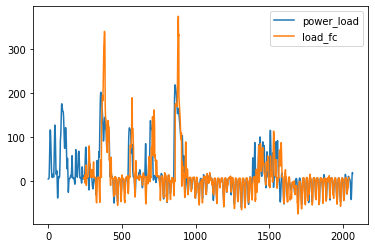

In [9]:
# %matplotlib
data[['power_load','load_fc']].plot()

In [10]:
data['demand_fc_k']=data.power_demand_
data['demand_fc_val_k']=data.power_demand_

In [11]:
conv_width_demand=7*day//dt
inputs_demand_k=['demand_fc_k']+inputs_demand[1:]
inputs_demand_k_val=['demand_fc_val_k']+inputs_demand[1:]
print(inputs_demand_k)
for n in range(10,length):
    data.loc[n*STEPS:n*STEPS+STEPS-1,'demand_fc_k']=demand_model.predict(data.loc[n*STEPS-conv_width_demand-STEPS+1:n*STEPS-1,inputs_demand_k].values[None,:,:]).flatten()
    data.loc[n*STEPS:n*STEPS+STEPS-1,'demand_fc_val_k']=demand_modelval.predict(data.loc[n*STEPS-conv_width_demand-STEPS+1:n*STEPS-1,inputs_demand_k_val].values[None,:,:]).flatten()    
data.demand_fc_k=data.demand_fc_k+data.bs
data.demand_fc_val_k=data.demand_fc_val_k+data.bs

['demand_fc_k', 'outside_temperature_fc', 'day_sin', 'day_cos', 'week_sin', 'week_cos']


## Demand

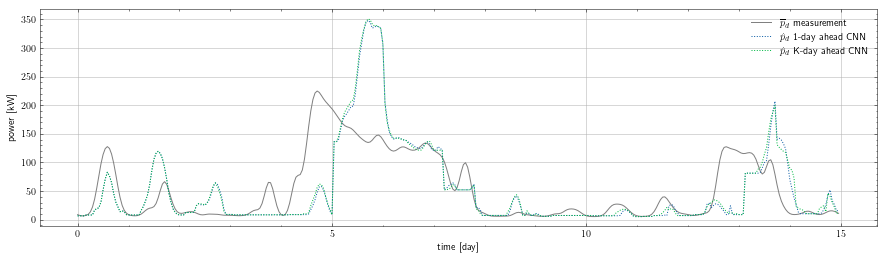

In [12]:
di=10
df=25

mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.grid'] = True
with plt.style.context('science'):
    plt.figure(figsize=(15,4))
    df=data[di*day//dt:df*day//dt]
    plt.plot(np.arange(len(df))/day*dt,df.power_demand.values,
             label=r'$\overline{p}_{d}$  measurement',color='grey')
    plt.plot(np.arange(len(df))/day*dt,df.demand_fc_k.values,label=r'$\hat{p}_{d}$ 1-day ahead CNN ',linestyle=':')
    plt.plot(np.arange(len(df))/day*dt,df.demand_fc.values,label=r'$\hat{p}_{d}$ K-day ahead CNN ',linestyle=':')    
#     plt.plot(np.arange(len(df))/day*dt,df.demand_fc_val_k.values,label=r'$\hat{p}_{d}$ demand CNN ',linestyle=':')
    plt.ylabel('power [kW]')
    plt.xlabel('time [day]')
    plt.legend(markerscale=8,loc='best')
    plt.xticks(np.arange(0,16,5))
#     plt.ylim([0,75])
    
# data[['power_demand','demand_fc','demand_fc_dev']].plot()
# plt.savefig('conv_td_mmnt_train.png')
plt.show()

## Load

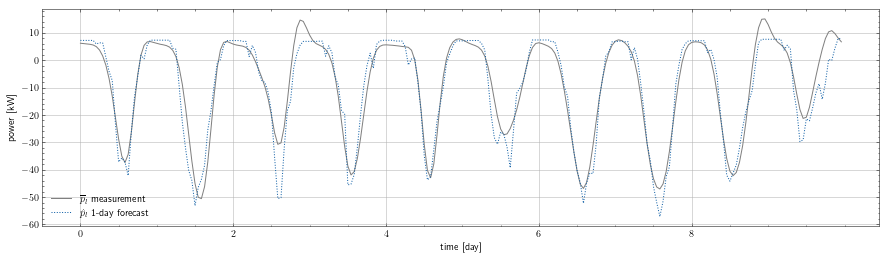

In [13]:
di=75
T=10
df=di+T

mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.grid'] = True
data['load_fc_k']=data.demand_fc_k-data.PV_fc
with plt.style.context('science'):
    plt.figure(figsize=(15,4))
    df=data[di*day//dt:df*day//dt]
    plt.plot(np.arange(len(df))/day*dt,df.power_load.values,
             label=r'$\overline{p}_{l}$  measurement',color='grey')
    plt.plot(np.arange(len(df))/day*dt,df.load_fc_k.values,label=r'$\hat{p}_{l}$ 1-day forecast',linestyle=':')
#     plt.plot(np.arange(len(df))/day*dt,df.load_fc.values,label=r'$\hat{p}_{d}$ K-day ahead CNN ',linestyle=':')    
#     plt.plot(np.arange(len(df))/day*dt,df.demand_fc_val_k.values,label=r'$\hat{p}_{d}$ demand CNN ',linestyle=':')
    plt.ylabel('power [kW]')
    plt.xlabel('time [day]')
    plt.legend(markerscale=8,loc='best')
    plt.xticks(np.arange(0,10,2))
#     plt.ylim([0,75])
    
# data[['power_demand','demand_fc','demand_fc_dev']].plot()
# plt.savefig('load_summer.png')
plt.show()

## Random initilization

<AxesSubplot:>

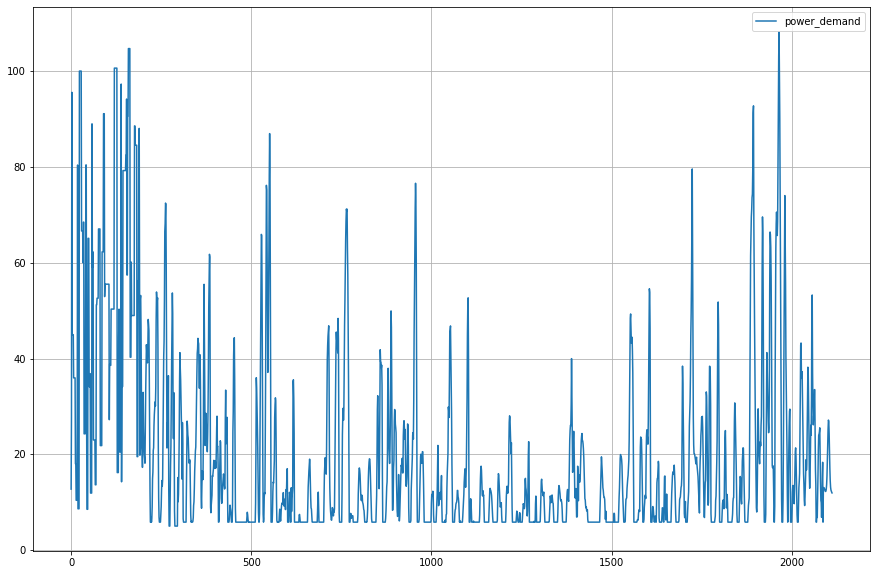

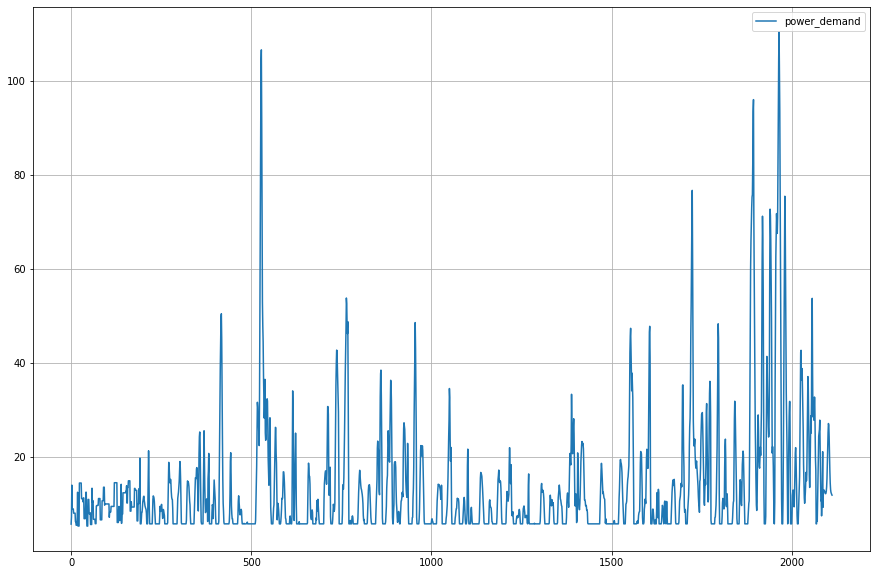

In [102]:

def demand_generator(df,model,p_bs=0,init_demand=None):
    data=df.copy()
    conv_width_demand=7*day//dt
    STEPS=day//dt
    Tin=conv_width_demand+STEPS-1
    inputs_demand=['power_demand','outside_temperature_fc',
        'day_sin','day_cos','week_sin','week_cos']        

    if init_demand is not None:
        if len(init_demand)<Tin:
            print('init_demand not long enough')
        init_demand=init_demand[:Tin]
        data.loc[:Tin-1,'power_demand']=init_demand
    length=len(data)*dt//day-1
    for n in range(Tin*dt//day+1,length):  
        data.loc[n*STEPS:n*STEPS+STEPS-1,'power_demand']=model.predict(data.loc[n*STEPS-Tin:n*STEPS-1,inputs_demand].values[None,:,:]).flatten()
    data.power_demand=data.power_demand+p_bs
    return data
    
init_demand=DemandSignal(period=9*day,dt=60,rep=1)
bins=4*day//dt
init_demand.step_signal(list(np.sort(np.random.rand(bins)))[:-1],np.random.rand(bins))  
pred=demand_generator(data,demand_model,init_demand=init_demand.signal*100,p_bs=5)
pred[['power_demand']].plot()
pred2=demand_generator(data,demand_model,init_demand=init_demand.signal*10,p_bs=5)
pred2[['power_demand']].plot()

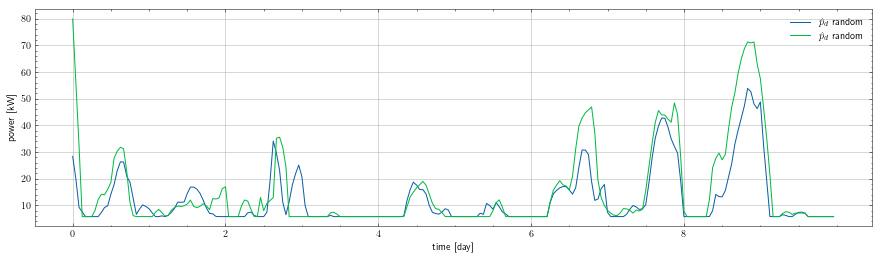

In [110]:
di=23
T=10
df=di+T

mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.grid'] = True
with plt.style.context('science'):
    plt.figure(figsize=(15,4))
    df1=pred[di*day//dt:df*day//dt]
    df2=pred2[di*day//dt:df*day//dt]
    plt.plot(np.arange(len(df2))/day*dt,df2.power_demand.values,label=r'$\hat{p}_{d}$ random')
    plt.plot(np.arange(len(df1))/day*dt,df1.power_demand.values,label=r'$\hat{p}_{d}$ random')
#     plt.plot(np.arange(len(df))/day*dt,df.load_fc.values,label=r'$\hat{p}_{d}$ K-day ahead CNN ',linestyle=':')    
#     plt.plot(np.arange(len(df))/day*dt,df.demand_fc_val_k.values,label=r'$\hat{p}_{d}$ demand CNN ',linestyle=':')
    plt.ylabel('power [kW]')
    plt.xlabel('time [day]')
    plt.legend(markerscale=8,loc='best')
    plt.xticks(np.arange(0,10,2))
#     plt.ylim([0,75])
    
# data[['power_demand','demand_fc','demand_fc_dev']].plot()
plt.savefig('demand_rnd_init.png')
plt.show()

# Demand

In [24]:
data=get_data('winter_demand_data.csv',npy=False)
mmntdata=get_data('winter_mmnt_data.csv',npy=False)

<AxesSubplot:xlabel='index'>

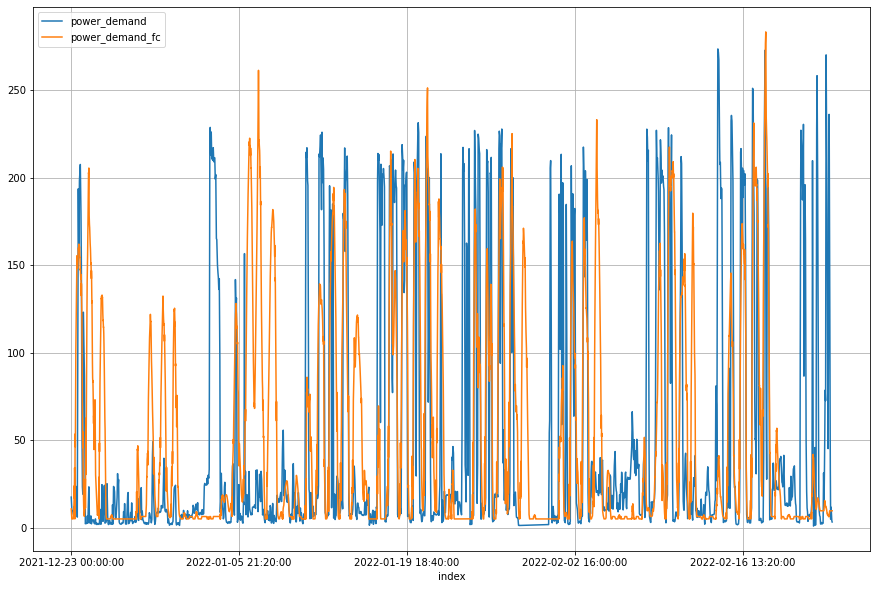

In [15]:
data[['power_demand','power_demand_fc']].plot()

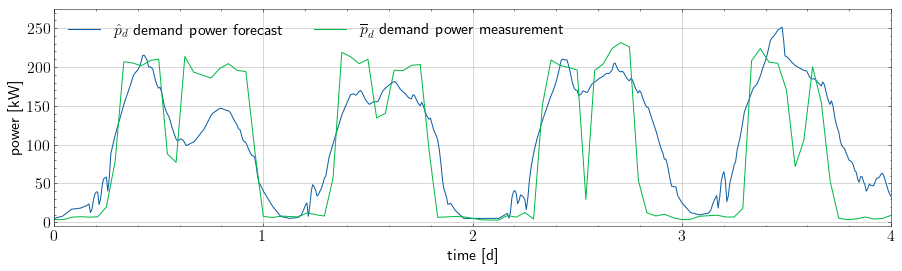

In [39]:
di=26
T=4
dt=1
dN=di+T

mpl.rcParams['figure.figsize'] = (10, 5)
mpl.rcParams['axes.grid'] = True
mpl.rcParams['font.size'] = 16
with plt.style.context('science'):
    plt.figure(figsize=(15,4))
    df1=data[di*day//dt:dN*day//dt]
    df2=mmntdata[di*day//dt:dN*day//dt]
#     plt.plot(np.arange(len(df2))/day*dt,df2.power_demand.values,label=r'$\hat{p}_{d}$ random')
    plt.plot(np.arange(len(df1))/day*dt,df1.power_demand_fc.values,label=r'$\hat{p}_{d}$ demand power forecast')
    plt.plot(np.arange(len(df1))/day*dt,df1.power_demand.values,label=r'$\overline{p}_{d}$ demand power measurement')    
#     plt.plot(np.arange(len(df))/day*dt,df.load_fc.values,label=r'$\hat{p}_{d}$ K-day ahead CNN ',linestyle=':')    
#     plt.plot(np.arange(len(df))/day*dt,df.demand_fc_val_k.values,label=r'$\hat{p}_{d}$ demand CNN ',linestyle=':')
    plt.ylabel('power [kW]')
    plt.xlabel('time [d]')
    plt.legend(markerscale=8,loc='best',ncol=2)

    plt.xticks(np.arange(0,10,1))
    plt.xlim([0,4])    
    plt.ylim([-5,275])
    
# data[['power_demand','demand_fc','demand_fc_dev']].plot()
plt.savefig('PP_demand_model.pdf')
plt.show()